In [1]:
import os
import numpy as np
import sys
import h5py
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
ROOT_DIR = '../'
sys.path.insert(0, os.path.abspath(f'/{ROOT_DIR}/heart_rhythm_analysis/'))    # make repo root importable

from heart_rhythm_analysis.get_data.CapnoBaseETL import CapnoBaseETL
from heart_rhythm_analysis.get_data.MimicETL import MimicETL

bSetUpDB = True

In [2]:
def load_as_df(file_path, filename, store_signals=True, bPlot=True):
    h5_path = f"{file_path}/{filename}.h5"
    hf = h5py.File(h5_path, "r")

    rows = []
    for subj in hf.keys():
        subj_grp = hf[subj]
        for win_id in subj_grp.keys():
            win_grp = subj_grp[win_id]
            rec_id = win_grp.attrs['rec_id']
            label = win_grp.attrs['label']
            raw_ppg = win_grp["raw_ppg"][:]
            proc_ppg = win_grp["proc_ppg"][:]
            raw_ekg = win_grp["raw_ekg"][:]
            ekg_fs = win_grp.attrs["ekg_fs"]
            ppg_fs = win_grp.attrs["ppg_fs"]
            notes = win_grp.attrs["notes"]
            row_data = {
                "subject": subj,
                "window_id": win_id,
                "rec_id": rec_id,
                "label": label,
                "ppg_fs_out": ppg_fs,
                "ekg_fs_out": ekg_fs,
                "raw_len": len(raw_ppg),
                "proc_len": len(proc_ppg),
                "duration_raw_s": len(raw_ppg) / ppg_fs,
                "duration_proc_s": len(proc_ppg) / ppg_fs,
                "notes": notes
            }
            if store_signals:
                row_data["raw_ppg"] = raw_ppg
                row_data["proc_ppg"] = proc_ppg
                row_data["raw_ekg"] = raw_ekg            
            rows.append(row_data)

    df = pd.DataFrame(rows)
    print(f"\nTotal windows: {len(df)}")
    if bPlot:
        first = df.iloc[np.random.randint(0, len(df))]
        y = first["proc_ppg"]
        t = np.arange(len(y)) / first.ppg_fs_out
        notes = first['notes']
        
        print(notes)
        fig = plt.figure(figsize=(15,7))
        plt.subplot(211)
        plt.plot(t, y)
        plt.title(f"Subject {first.subject} – Window {first.window_id}\nfs={first.ppg_fs_out} Hz")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")

        plt.subplot(212)
        y = first["raw_ekg"]
        t = np.arange(len(y)) / first.ekg_fs_out
        plt.plot(t,y)
        plt.title(f"fs={first.ekg_fs_out} Hz")
        plt.tight_layout()
        plt.show()
    hf.close()
    return df

# Create Capno Dataset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/capnobase/data/mat')
    out_path = os.path.join('../data/processed/length_full/capnobase_db')
    out_filename = 'capnobase_db'
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    fs_in = 100.00
    fs_out = 100.00

    config = {
    "input_dir"      : root_path,
    "output_dir"     : out_path,
    "window_size_sec": 30,
    "fs_in"          : fs_in,
    "fs_out"   : fs_out,
    "lowpass_cutoff" : (fs_out / 2),
    "fir_numtaps"    : 129,
    "zero_phase"     : True,
    "out_filename" :  out_filename
}
    if bSetUpDB:
        etl = CapnoBaseETL(config)
        h5file = etl.process_all()
        print(f"Saved windows HDF5 to {h5file}")
    df = load_as_df(out_path,out_filename)

    display(df.head(10))
    return df
if __name__ == "__main__":
    df_capnobase = main()

# MIMIC III AF DATASET

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_af_data.mat')
    out_filename = 'mimic_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 125.00,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "decimate_signal": False,
        "out_filename": out_filename
    }
    # if bSetUpDB:
    #     etl = MimicETL(config)
    #     out_file = etl.process()
    #     print("Saved AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df

if __name__ == "__main__":
    df_mimc_af = main()
    

# MIMIC III Non-AF Dataset

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_non_af_data.mat')
    out_filename = 'mimic_non_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_non_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 125.00,
        "window_size_sec": 30,
        "scale_type": None,
        "decimate_signal": False,
        "zero_phase": True,
        "out_filename": out_filename   
    }
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print("Saved non AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimc_nonaf = main()

# MIMIC III General Subset

Loading ../data/raw/mimic3_data/test_mimic3_struct.mat
Saved General MIMIC III windows to ../data/processed/length_full/mimic3_db/mimic3_db.h5

Total windows: 3000



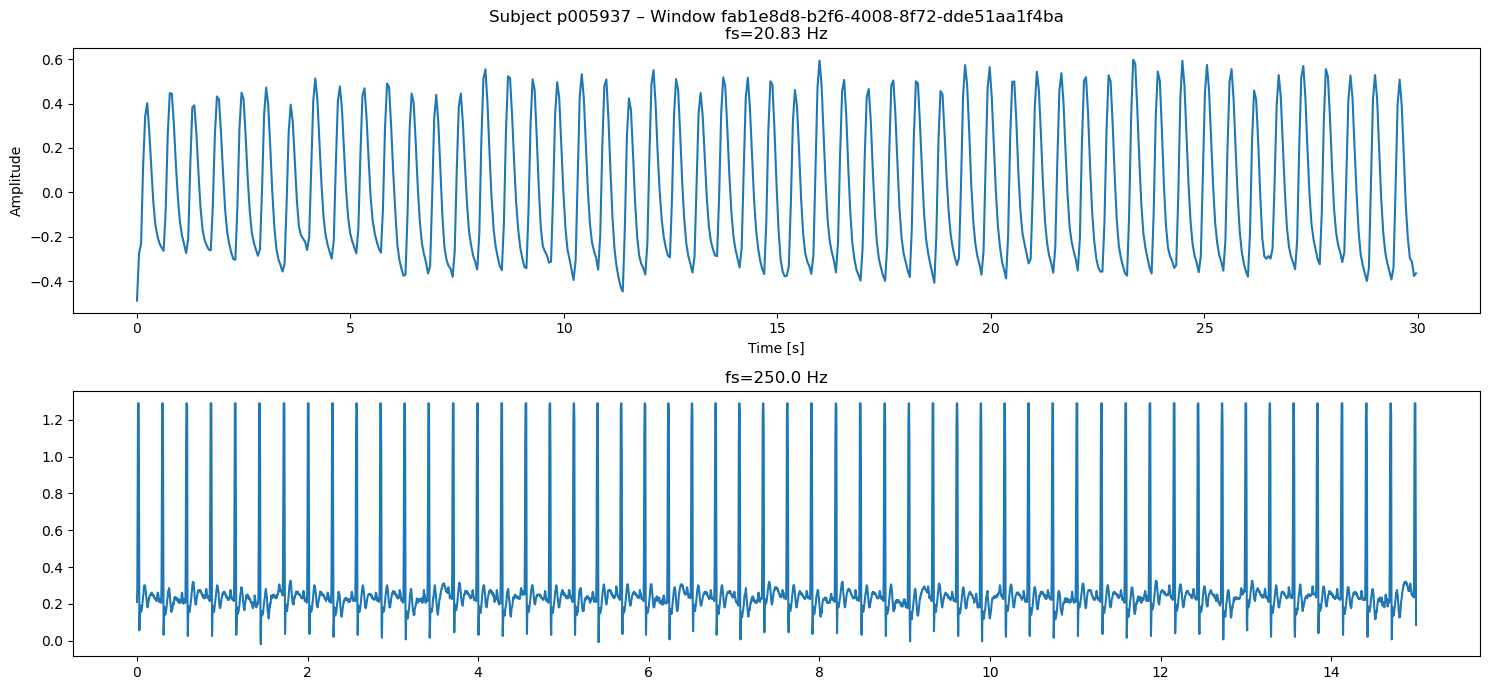

,subject,window_id,rec_id,label,ppg_fs_out,ekg_fs_out,raw_len,proc_len,duration_raw_s,duration_proc_s,notes,raw_ppg,proc_ppg,raw_ekg
0,p000160,0440389a-e597-4f7c-993b-6fd6f3c61423,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.520039100684262, 0.5210166177908113, 0.5210...","[-0.7654532, 0.23454678, -0.043461144, 0.07612...","[0.5901960784313726, 0.5745098039215686, 0.584..."
1,p000160,071af268-d4bf-4c3c-9aaf-b23b52f9cb3d,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.5219941348973607, 0.52297165200391, 0.52394...","[-0.76632375, 0.23367625, -0.13615662, -0.0319...","[0.3352941176470588, 0.4, 0.49411764705882355,..."
2,p000160,10e62f89-bb7e-425e-bad6-cf32c9dcdb80,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.7487781036168133, 0.7429130009775171, 0.733...","[-0.13722605, 0.27509737, -0.15881684, -0.2267...","[0.7803921568627451, 0.7215686274509804, 0.776..."
3,p000160,14109874-5ab9-42c2-8bbd-7ff9de6b1493,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.5620723362658846, 0.5620723362658846, 0.562...","[-0.5946466, 0.17991132, -0.024530888, 0.10790...","[0.6254901960784314, 0.6294117647058823, 0.625..."
4,p000160,231feefa-332f-4165-bfca-b85c0bce3a50,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.512218963831867, 0.5102639296187683, 0.5083...","[-0.1765472, 0.060587704, -0.004865229, 0.0317...","[0.5509803921568628, 0.5294117647058824, 0.539..."
5,p000160,2624f626-9d4e-4633-86e5-a887d11aeef7,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.41055718475073316, 0.4066471163245357, 0.40...","[-0.51687086, -0.078476965, -0.22280553, -0.17...","[0.5745098039215686, 0.6058823529411764, 0.790..."
6,p000160,285a7d8a-8bba-4419-ba54-aa446ba83433,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.512218963831867, 0.5102639296187683, 0.5083...","[-0.82583904, 0.17416096, -0.1298222, 0.027549...","[0.596078431372549, 0.5843137254901961, 0.6058..."
7,p000160,2dad526e-1dd9-4223-be1c-3b511229eeb5,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.3724340175953079, 0.3734115347018573, 0.379...","[-0.6468594, -0.21138349, -0.2856676, -0.15251...","[0.6901960784313725, 0.49019607843137253, 0.56..."
8,p000160,2e0a08c5-8642-411e-b2bc-d971b561a015,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.39882697947214074, 0.39589442815249265, 0.3...","[-0.7066555, -0.20167202, -0.2308723, -0.02844...","[0.6705882352941176, 0.6509803921568628, 0.629..."
9,p000160,2e9154c5-837f-4c1b-af3d-cbb252b28a10,3531764_0003,-1,20.83,250.0,3750,625,180.028805,30.004801,,"[0.4232649071358749, 0.4222873900293255, 0.421...","[-0.74337286, -0.15685272, -0.22537476, 0.0240...","[0.7764705882352941, 0.7509803921568627, 0.735..."


In [5]:
def main():
    root_path = os.path.join('../data/raw/mimic3_data/test_mimic3_struct.mat')
    out_filename = 'mimic3_db'
    out_path = os.path.join('../data/processed/length_full/mimic3_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "decimate_signal": True,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    bSetUpDB = True
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print("Saved General MIMIC III windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()

# MIMIC IV Data

Loading ../data/raw/mimic4_data/test_mimic4_struct.mat
Saved  MIMIC IV  windows to ../data/processed/length_full/mimic4_db/mimic4_db.h5

Total windows: 2100



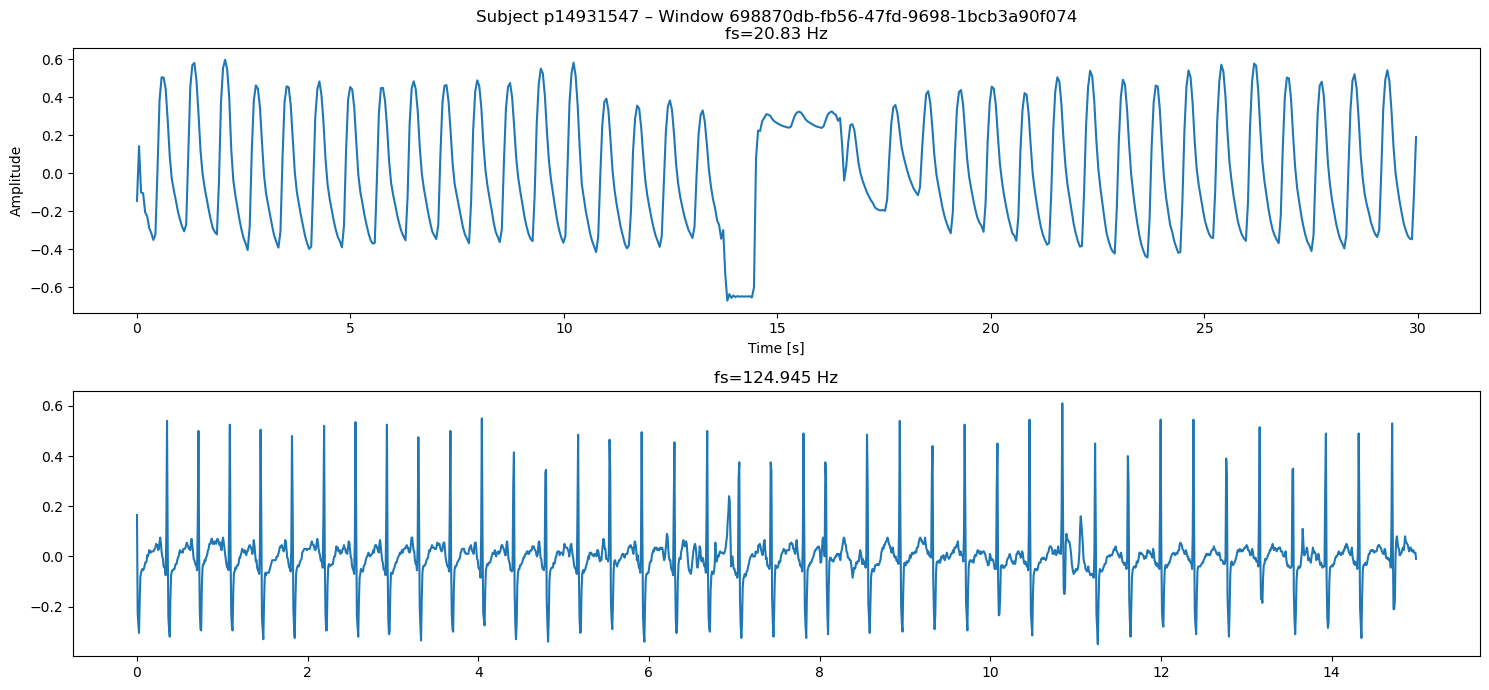

,subject,window_id,rec_id,label,ppg_fs_out,ekg_fs_out,raw_len,proc_len,duration_raw_s,duration_proc_s,notes,raw_ppg,proc_ppg,raw_ekg
0,p10020306,0050d3be-64c1-459b-83c1-6d2470f4c17b,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.646240234375, 0.635498046875, 0.62841796875...","[0.104712784, 0.45326704, 0.31469446, 0.366, 0...","[-0.03, -0.04, -0.045, -0.035, -0.03, -0.01, 0..."
1,p10020306,0070c7b1-c34c-400d-ade8-705091af159b,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.625, 0.62060546875, 0.6123046875, 0.6040039...","[-0.4714237, 0.058437586, -0.15497258, -0.1016...","[-0.01, -0.025, -0.035, -0.04, -0.045, -0.035,..."
2,p10020306,0326b626-f655-40ac-af5a-a903c1eb0038,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.55810546875, 0.55810546875, 0.5498046875, 0...","[-0.3923779, 0.00985536, -0.15671772, -0.12104...","[0.015, 0.005, -0.03, -0.05, -0.065, -0.065, -..."
3,p10020306,057d4d60-11aa-4237-a70e-5c2bd715c4bc,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2815454, -0.2815454, -0.2815454, -0.281545...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,p10020306,076e6ee0-54a2-4a65-8a91-d201ad5698ff,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.589111328125, 0.58203125, 0.57470703125, 0....","[-0.32114658, 0.09134585, -0.02685079, 0.06130...","[-0.095, -0.17, -0.23, -0.255, -0.265, -0.23, ..."
5,p10020306,0bc8d7e2-42c0-4429-bf5f-e79f7f42df2e,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.39990234375, 0.39990234375, 0.39990234375, ...","[-0.5524958, -0.25064227, -0.31983125, -0.2749...","[0.03, 0.04, 0.03, 0.025, 0.025, 0.015, 0.015,..."
6,p10020306,0d3c46e9-20aa-4e61-9d78-81bf98104271,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.662353515625, 0.654052734375, 0.6416015625,...","[-0.21960741, 0.5305476, 0.19109121, 0.2331933...","[-0.01, -0.015, -0.015, -0.015, -0.005, -0.005..."
7,p10020306,0ed85152-7d34-4d8a-ab2c-a3c8aafab062,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.670654296875, 0.69140625, 0.71240234375, 0....","[0.089095235, 0.5332592, 0.45843357, 0.5056904...","[0.485, 0.16, -0.085, -0.08, -0.09, -0.095, -0..."
8,p10020306,1a29b500-b575-479a-b104-dd55b2823149,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.708251953125, 0.708251953125, 0.7041015625,...","[-0.13294566, 0.5885029, 0.33483702, 0.4136168...","[-0.02, -0.015, -0.02, -0.03, -0.015, 0.0, 0.0..."
9,p10020306,1f2ded11-77c0-4f10-a635-c7a948ea8ef7,83404654_0019,-1,20.83,124.945,1874,625,89.966395,30.004801,,"[0.332763671875, 0.332763671875, 0.33276367187...","[-0.537494, -0.2326951, -0.3358753, -0.3218440...","[-0.02, -0.015, -0.01, -0.005, -0.015, -0.025,..."


In [7]:
np.random.seed(42)
def main():
    substring = ''
    file_name = f'_{substring}' if len(substring) > 0 else ""
    root_path = os.path.join(f'../data/raw/mimic4_data/test_mimic4{file_name}_struct.mat')
    out_filename = f'mimic4{file_name}_db'
    out_path = os.path.join(f'../data/processed/length_full/{out_filename}')

    if not os.path.exists(out_path):
        os.mkdir(out_path)
    fs_in = 62.5
    fs_out = 20.83
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": fs_in,
        "fs_out": fs_out,
        "window_size_sec": 30,
        "scale_type": "norm",
        "decimate_signal": True,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    if bSetUpDB:
        etl = MimicETL(config)
        out_file = etl.process()
        print(f"Saved {substring} MIMIC IV  windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic4_gen = main()


In [ ]:
df_capnobase['subject'].unique()
df_mimc_af['subject'].unique()
df_mimc_nonaf['subject'].unique()
df_mimic_gen['subject'].unique()
df_mimic4_gen['subject'].unique()

mimic3_non_af_subject_ids = (df_mimc_nonaf['subject'].unique().squeeze())
mimic3_af_subject_ids = (df_mimc_af['subject'].unique().squeeze())
mimic3_general_subject_ids = (df_mimic_gen['subject'].unique().squeeze())

all_mimic3_subjects = []
# all_mimic3_subjects.append(mimic3_non_af_subject_ids[:])
# all_mimic3_subjects.append(mimic3_af_subject_ids[:])
# all_mimic3_subjects.append(mimic3_general_subject_ids[:])
all_mimic3_subjects = np.concatenate((mimic3_non_af_subject_ids,mimic3_af_subject_ids,mimic3_general_subject_ids))
print(len(all_mimic3_subjects),len(np.unique(all_mimic3_subjects)),all_mimic3_subjects,)

In [ ]:
from heart_rhythm_analysis.get_data.prepare_dataset import split_and_save

ROOT_PATH = '../data/processed/length_full'
file_paths = [f"{ROOT_PATH}/mimic3_db/mimic3_db.h5", f"{ROOT_PATH}/mimic4_db/mimic4_db.h5"]
out_path = '../data/development_dataset/length_full'
train_path, test_path = split_and_save(file_paths, train_ratio=0.8, output_dir=out_path)